# Get the model converging
Since the model is not converging (the loss is not decreasing at all), I need to find where the model is stuck and fix it. These are the things I can think of:

-   Is the spectrum masked out too much?
-   Is the model too complex?
-   Is the data too noisy? 
-   Is loss too high?
-   Try batch norm?
-   Try larger learning rate?

## Functions

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def eval(model, spe_arr):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(24)
        spe = torch.from_numpy(spe_arr)
        return model(spe.unsqueeze(0).float())
    
def unpatchify(mask, pred, model):
    pred_un = model.unpatchify(pred)
    pred_un_arr = pred_un.squeeze(0).numpy()

    mask_arr = mask.squeeze(0).numpy()
    mask_un_arr = np.array([])
    for i in mask_arr:
        mask_un_arr = np.concatenate((mask_un_arr, np.repeat(i, 16)))
    mask_un_arr = mask_un_arr.astype(int)

    return pred_un_arr, mask_un_arr

def plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=30):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    scale = .001
    channel = np.arange(1, len(spe_arr)+1)
    for ax in axes:
        if ax == axes[0]: # normal view
            ax.bar(channel, mask_un_arr*(spe_arr.max()*scale), color='gray', alpha=0.5, label='masked')
            ax.plot(channel, spe_arr*scale, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr*scale, alpha=.6, label='pred')
            ax.set_ylim(0, spe_arr.max()*scale)
            ax.set_ylabel('Counts (K)')
        else: # zoom in
            ax.bar(channel, mask_un_arr*ymax, color='gray', alpha=0.5, label='masked')
            ax.plot(channel, spe_arr, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr, alpha=.6, label='pred')
            ax.set_ylim(0, ymax)
            ax.set_ylabel('Counts')

        ax.set_xlabel('Channel')
        ax.legend()
    plt.show()


## Lower the mask ratio
The training settings are as follows:
```
ViT model: base
Constant learning rate: 1e-5
Optimizer: AdamW (betas=(0.9, 0.95)) 
Clips gradient norm
Patch size: 16
Mask ratio: 0.1
Batch size: 64
Epochs: 100
Step size: 10 (batches)
```
Details please refer to `models_mae.py` and `test_mask_ratio.py`.


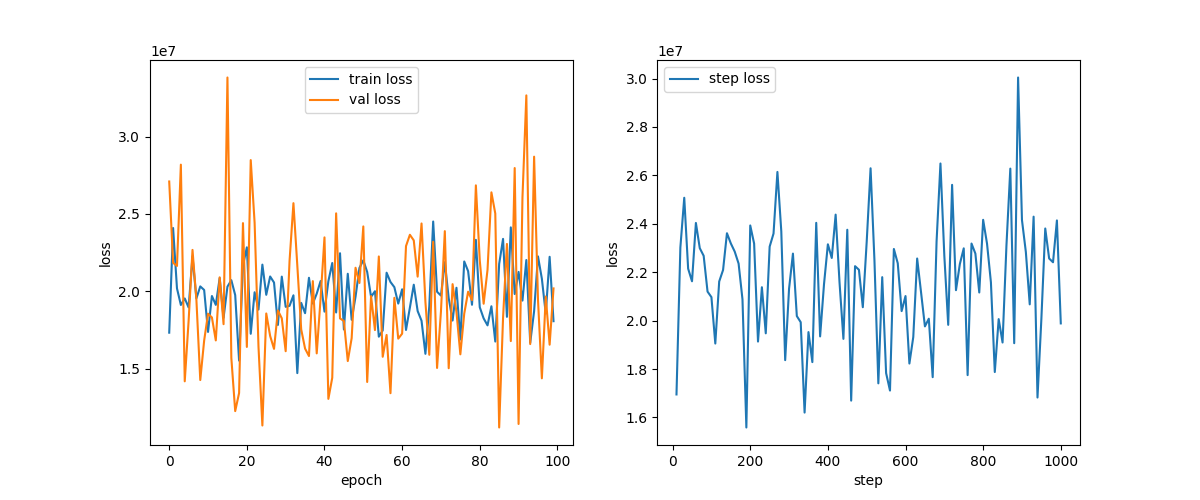

In [1]:
# The low mask results
from IPython.display import Image
Image(filename='results/loss_20231206.png')

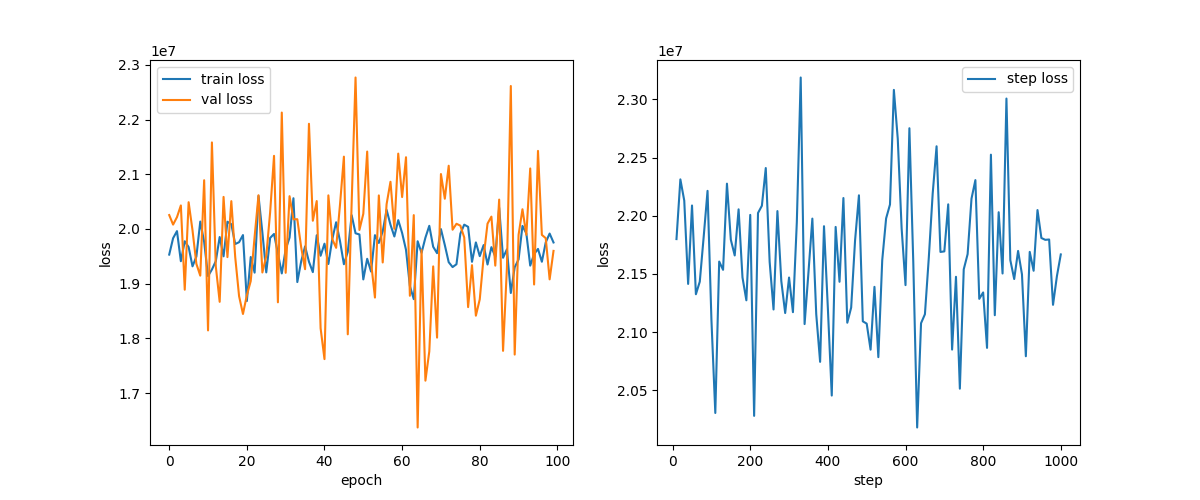

In [ ]:
# the high mask (0.75) results
from IPython.display import Image
Image(filename='results/loss_20231130.png')

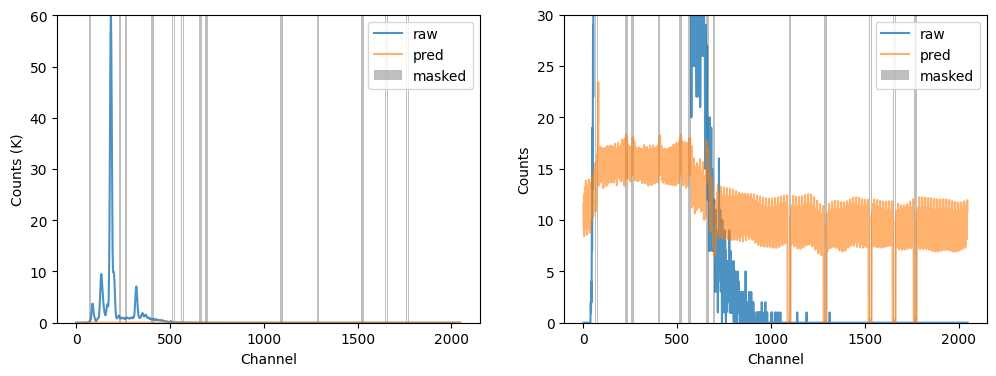

In [44]:
from torch import nn
from models_mae import MaskedAutoencoderViT
from functools import partial
from test_mask_ratio import get_dataloader

model = MaskedAutoencoderViT(
        patch_size=16, mask_ratio=0.1, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
model.load_state_dict(torch.load('models/mae_vit_base_patch16_20231206.pth'))

dataloader = get_dataloader(batch_size=64)
spe_arr = dataloader['train'].dataset[0]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr)

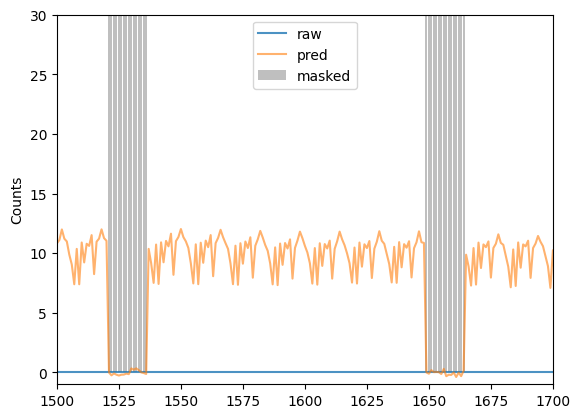

In [57]:
channel = np.arange(1, len(spe_arr)+1)
xmax = (1500, 1700) 
ymax = 30
plt.bar(channel, mask_un_arr*ymax, color='gray', alpha=0.5, label='masked')
plt.plot(channel, spe_arr, alpha=.8, label='raw')
plt.plot(channel, pred_un_arr, alpha=.6, label='pred')
plt.xlim(xmax)
plt.ylim(-1, ymax)
plt.ylabel('Counts')
plt.legend()
plt.show()

The loss of training from 0.1 mask ratio is still not decreasing, either. The loss is overall similar but varies larger than the previous model, trained from 0.75 mask ratio. The better performance at the ramps and low counts region disappears. Hence, the masking is actually helping rather than being a problem. 

But, the relatively good performace at the masked part remains.



## Replace transformer with FCN
The encoder-decoder structure remains the same. The only difference is that the transformer is replaced with fully connected networks. 

The training settings are as follows:
```
Model: Linear models
Constant learning rate: 1e-5
Optimizer: AdamW (betas=(0.9, 0.95)) 
Clips gradient norm
Patch size: 16
Mask ratio: 0.75
Batch size: 64
Epochs: 100
Step size: 10 (batches)
No layer norm
```
Details please refer to `models_fcn.py` and `test_fcn.py`.


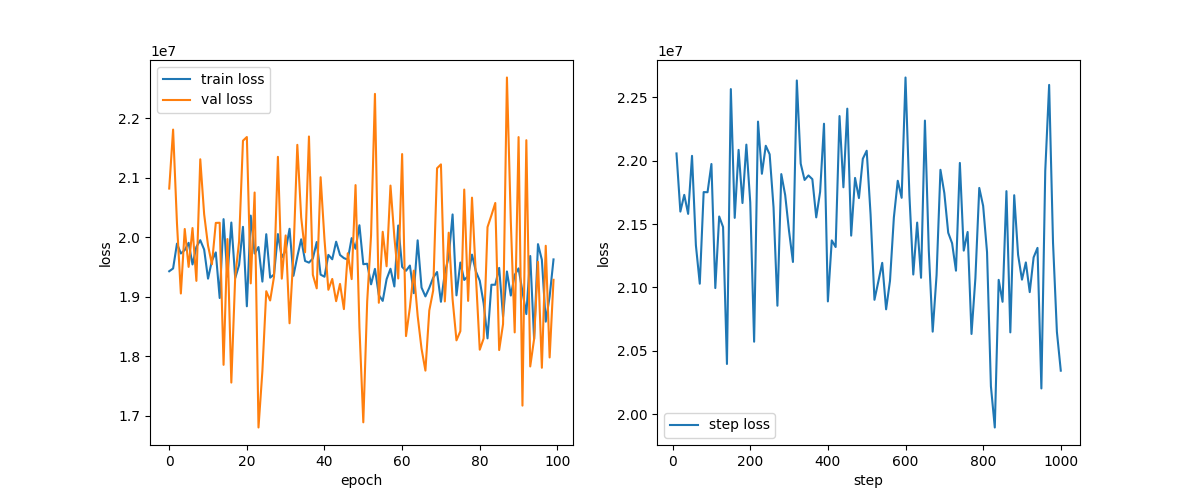

In [3]:
from IPython.display import Image
Image(filename='results/loss_liner_20231206.png')

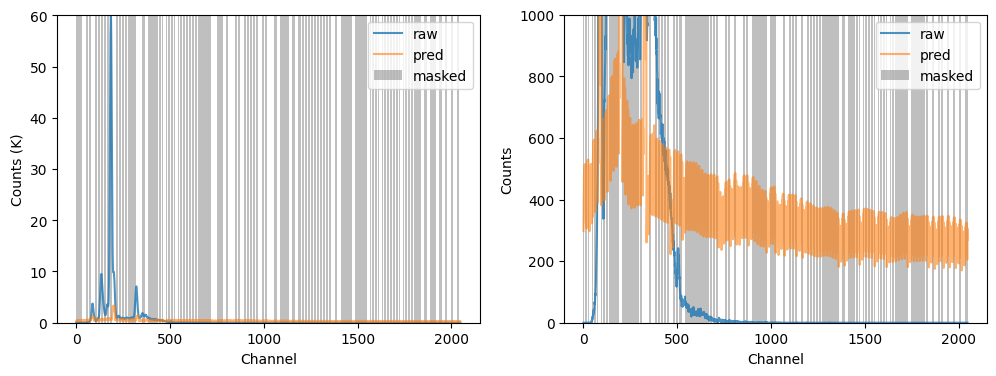

In [40]:
from models_fcn import SimpleLinear
model = SimpleLinear()
model.load_state_dict(torch.load('models/linear_patch16_20231206.pth'))

dataloader = get_dataloader(batch_size=64)
spe_arr = dataloader['train'].dataset[0]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=1000)

The loss from a linear-based model with the same settings is similar to the transformer-based model. But in detail, the predictions of unmasked parts are slightly better than the transformer-based model. The weired behavior that relatively good performance at the masked low counts parts disappears. It seems that the model can learn a little bit even though it's not converged?

## Train and validate on only one spectrum
The training settings are as follows:
```
ViT model: base
Constant learning rate: 1e-5
Optimizer: AdamW (betas=(0.9, 0.95)) 
Clips gradient norm
Patch size: 16
Mask ratio: 0.75
Batch size: 64
Epochs: 100
Step size: 10 (batches)
```
Details please refer to `models_mae.py` and `test_data.py`.


In [59]:
# trick the model to read only 0.csv
import pandas as pd

df = pd.read_csv('data/info_20231121.csv')
df['dirname'] = ['0.csv' for _ in range(len(df))]
df.head()

,dirname,composite_id,cps,core,composite_depth_mm,section_depth_mm,filename,section
0,0.csv,SO264-15-2_00010,38706,SO264-15-2,10,10,SO264-15-2_0000 10.0mm 10s 10kV 150uA No-F...,0
1,0.csv,SO264-15-2_00020,43223,SO264-15-2,20,20,SO264-15-2_0000 20.0mm 10s 10kV 150uA No-F...,0
2,0.csv,SO264-15-2_00030,107525,SO264-15-2,30,30,SO264-15-2_0000 30.0mm 10s 10kV 150uA No-F...,0
3,0.csv,SO264-15-2_00040,127305,SO264-15-2,40,40,SO264-15-2_0000 40.0mm 10s 10kV 150uA No-F...,0
4,0.csv,SO264-15-2_00050,130242,SO264-15-2,50,50,SO264-15-2_0000 50.0mm 10s 10kV 150uA No-F...,0


In [60]:
df.to_csv('data/info_1data_20231206.csv', index=False)

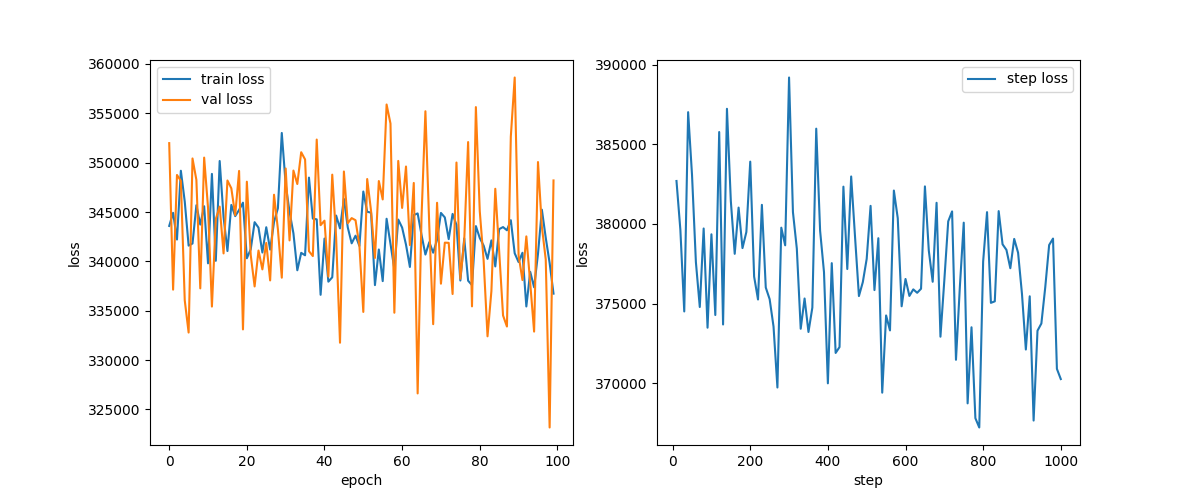

In [61]:
from IPython.display import Image
Image(filename='results/loss_1data_20231206.png')

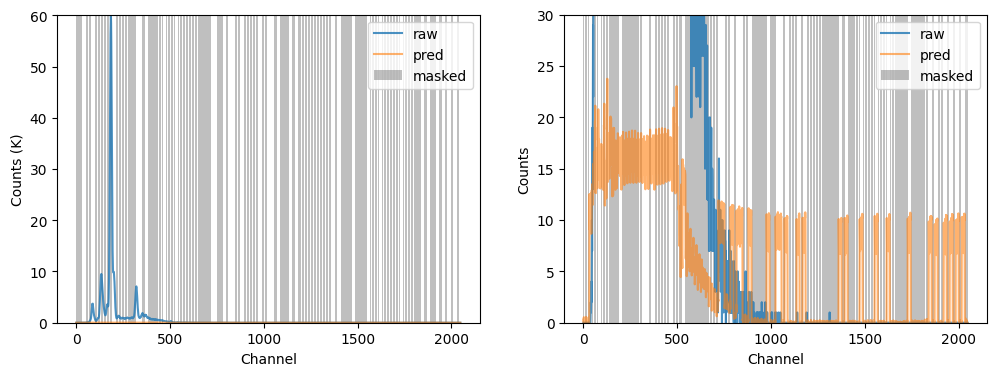

In [63]:
from models_mae import mae_vit_base_patch16
model = mae_vit_base_patch16()
model.load_state_dict(torch.load('models/mae_vit_base_patch16_1data_20231206.pth'))

dataloader = get_dataloader(batch_size=64)
spe_arr = dataloader['train'].dataset[0]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=30)

Even though the loss is smaller, it's still not converging. The weired behavior that relatively good performance at the masked low counts part exists like the previous transformer-based model. But the fit to the ramps disappears. Since the one-data training has the similar loss with the real data, I don't think the real data is too noisy and become a problem.

## Increase the learning rate
Our counts compare to the MAE image pixels are extremly larger. This also reflects on the large loss (1e7 scale). Perhaps I can batch normalize the data to stablize it. But the model already has layer normalization, which is doing the every similar job. So, I think maybe I can try another way: increase the learning rate (by two orders), going bigger step in each backpropagation, to see if it helps.

The training settings are as follows:
```
ViT model: base
Constant learning rate: 1e-3
Optimizer: AdamW (betas=(0.9, 0.95)) 
Clips gradient norm
Patch size: 16
Mask ratio: 0.75
Batch size: 64
Epochs: 100
Step size: 10 (batches)
```
Details please refer to `models_mae.py` and `test_pretrain.py`.


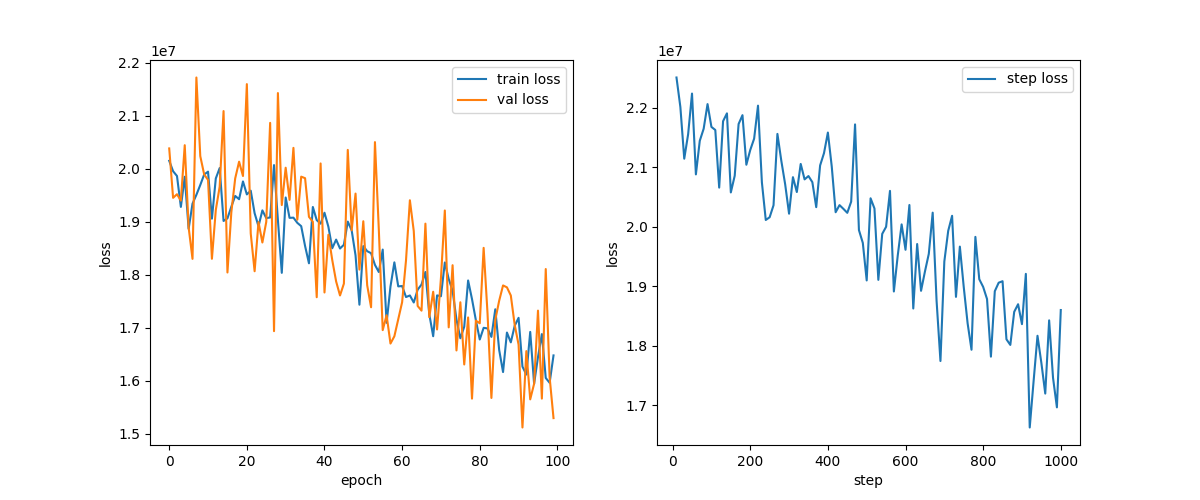

In [64]:
from IPython.display import Image
Image(filename='results/loss_1e-3_20231206.png')

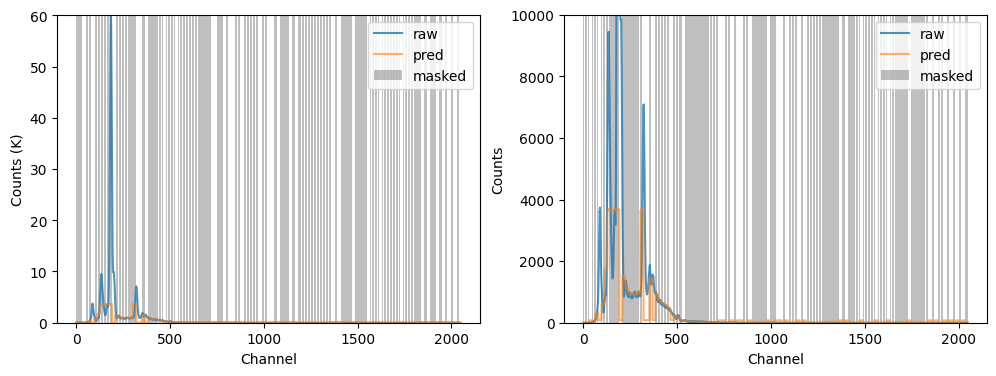

In [66]:
from models_mae import mae_vit_base_patch16
model = mae_vit_base_patch16()
model.load_state_dict(torch.load('models/mae_vit_base_patch16_1e-3_20231206.pth'))

dataloader = get_dataloader(batch_size=64)
spe_arr = dataloader['train'].dataset[0]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=10000)

IT WORKS!!!!!!!

The weired behavior that relatively good performance at the masked low counts part is still there. 